In [17]:
#Import relevant APIs
import numpy as np
import pandas as pd
import tweepy as tw
import yfinance as yf
import sys
import matplotlib.pyplot as plt
%matplotlib inline
from datetime import date
from datetime import timedelta
from time import process_time

Setting up Twitter Authentication:

In [18]:
from tweepy import OAuthHandler
from tweepy import API

apiKey = 'sUY1UAhfmauoDAqodxPJCmE1d'
apiSecret = 'nRrYuBn8X1MauIFfyznAXdwdLsTcVReytlIUpsfjiI2GncodX0'
accessToken = '3295318197-LMzVBdXwZPbIgJU8Fd0ksjT8mEOES2HRYC2J2ha'
accessSecret = 'RgqkfaXowXGk1JaKs0jTOIvGVjZbGnL32bsPk4DuzohBf'

auth = OAuthHandler(apiKey, apiSecret)
auth.set_access_token(accessToken, accessSecret)
api = API(auth, wait_on_rate_limit = True)

Storing methods: Getting Ticker data and storing in Pandas DataFrame, then dict with only percent change:

In [19]:
tickers = ['TSLA','AAPL', 'FB', 'ZM', 'ADBE', 'ADI', 'ADP', 'ADSK', 'ALGN', 'ALXN', 'AMAT', 'AMD', 'AMGN', 'AMZN',
          'ANSS', 'ASML', 'ATVI', 'AVGO', 'BIDU', 'BIIB', 'BKNG', 'BMRN', 'CDNS', 'CDW', 'CERN', 'CHKP', 'CHTR', 'CMCSA',
          'COST', 'CPRT', 'CSCO', 'CSX', 'CTAS', 'CTSH', 'CTXS', 'DLTR', 'DOCU', 'DXCM', 'EA', 'EBAY', 'EXC', 'EXPE',
          'FAST', 'FISV', 'FOX', 'GILD', 'GOOGL', 'IDXX', 'ILMN', 'INCY', 'INTC', 'INTU', 'ISRG', 'JD', 'KDP', 'KHC',
          'KLAC', 'LBTYA', 'LRCX', 'LULU', 'MAR', 'MCHP', 'MDLZ', 'MELI', 'MNST', 'MRNA', 'MSFT', 'MU', 'MXIM',
          'NFLX', 'NTES', 'NVDA', 'NXPI', 'ORLY', 'PAYX', 'PCAR', 'PDD', 'PEP', 'PYPL', 'QCOM', 'REGN', 'ROST', 'SBUX',
          'SGEN', 'SIRI', 'SNPS', 'SPLK', 'SWKS', 'TCOM', 'TMUS', 'TTWO', 'TXN', 'ULTA', 'VRSK', 'VRSN', 'VRTX',
          'WBA', 'WDAY', 'XEL', 'XLNX']
perChange = {}

def storePercentChange():
    global end_date
    global days_prior
    global start_date
    end_date = date.today()
    days_prior = input("Enter the number of days to retrieve selected ticker & tweet data (max 7 days, min 2 days):  ")
    start_date = end_date - timedelta(days=int(days_prior))
    weekno = start_date.weekday()
    if weekno < 5 and int(days_prior) <= 7 and int(days_prior) >= 2:
        stock_data = yf.download(tickers, start=start_date, end=end_date, progress=False, group_by='ticker')
        for tick in tickers:
            percent_change = (((stock_data[tick]['Close'])[-1] - (stock_data[tick]['Close'])[str(start_date)])/
                (stock_data[tick]['Close'])[str(start_date)])*100
            perChange[tick] = round(abs(percent_change), 2)
    elif weekno >=5:
        sys.exit("Input leads to a date on the weekend. Exiting...")
    elif int(days_prior) > 7 or int(days_prior) < 2:
        sys.exit("Input does not match constraints. Exiting...")

Sorting Algorithms for all tickers in NQ100:

In [20]:
ticker_PerList = []

def makePairs():
    for index, (key,value) in enumerate(perChange.items()):
        ticker_PerList.insert(index,(value,key))
        
def selectionSort(ticker):
    length = len(ticker)
    for index in range(length): 
        largest = index 
        for select in range(index+1, length): 
            if ticker[largest][0] < ticker[select][0]: 
                largest = select         
        ticker[index], ticker[largest] = ticker[largest], ticker[index] 
        
def heapify(ticker, n, index): 
    smallest = index  
    left = 2 * index + 1      
    right = 2 * index + 2     
    if left < n and ticker[left][0] < ticker[smallest][0]: 
        smallest = left
    if right < n and ticker[right][0] < ticker[smallest][0]: 
        smallest = right
    if smallest != index: 
        ticker[index],ticker[smallest] = ticker[smallest],ticker[index]  # swap 
        heapify(ticker, n, smallest) 

def heapSort(ticker): 
    length = len(ticker) 
    for index in range(length // 2 - 1, -1, -1): 
        heapify(ticker, length, index) 
    for index in range( length-1, 0, -1): 
        ticker[index], ticker[0] = ticker[0], ticker[index]    
        heapify(ticker, index, 0) 

Selecting Top 5 & Bottom 5 Tickers in terms of % change and storing in list and dict:

In [21]:
perChangeSelected = {}

def storeSelectTickers():
    global selected_tickers
    selected_tickers = ticker_PerList[:5]
    selected_tickers += ticker_PerList[-5:]
    
def storeSelectPer():
    for x in range(len(selected_tickers)):
        perChangeSelected[selected_tickers[x][1]] = selected_tickers[x][0]

Searching Twitter tweets using Tweepy:

In [22]:
tweetsDict = {}

def searchTweets():
    public_tweets = []
    count = 0
    counter = 0
    maxID = 0
    for tick in perChangeSelected:
        while counter < 10:
            if maxID > 0:
                public_tweets = api.search(q = '$'+tick+' -filter:retweets', count = 100, 
                                           since = start_date, until = end_date, max_id = maxID)
            else:
                public_tweets = api.search(q = '$'+tick+' -filter:retweets', count = 100, 
                                           since = start_date, until = end_date)
            count += len(public_tweets)
            maxID = public_tweets[-1].id
            counter += 1
        tweetsDict[tick] = count 
        counter = 0
        count = 0
        maxID = 0

Merging two dicts on Ticker axis, storing in DF and Plotting:

In [23]:
def mergeAndPlot():
    corr_list = [perChangeSelected, tweetsDict]
    correlation = {}

    for tick in perChangeSelected.keys():
        correlation[tick] = tuple(correlation[tick] for correlation in corr_list)
    
    initial_table = pd.DataFrame(correlation)
    final_table = initial_table.transpose()
    final_table.columns = ['% Change', 'Number of Tweets']
    print(final_table)
    final_table.plot(kind = 'scatter', x='Number of Tweets', y='% Change', title = 'Tweets vs. % Change')
    

Enter the number of days to retrieve selected ticker & tweet data (max 7 days, min 2 days):   5


1. Selection Sort
2. Heap Sort


Select sorting algorithm to sort tickers by % change in descending order (1 or 2):  2


       % Change  Number of Tweets
SPLK      21.11             974.0
MU        14.43             986.0
ZM        14.29             981.0
WBA       14.21             458.0
LBTYA     11.10              44.0
JD         0.19             745.0
AMZN       0.17             987.0
MSFT       0.14             980.0
MRNA       0.14             979.0
TTWO       0.12             168.0


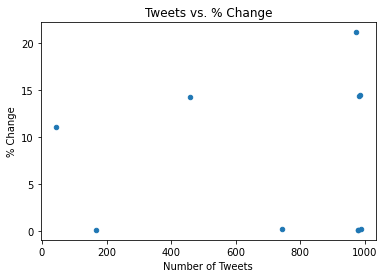

In [24]:
start_time = process_time()
storePercentChange()

print("1. Selection Sort")
print("2. Heap Sort")
select_sort = input("Select sorting algorithm to sort tickers by % change in descending order (1 or 2): ")

if int(select_sort) == 1:
    makePairs()
    selectionSort(ticker_PerList)
elif int(select_sort) == 2:
    makePairs()
    heapSort(ticker_PerList)

storeSelectTickers()
storeSelectPer()
searchTweets()
mergeAndPlot()